# Data-X
## Tutorial on Regularization, Ridge, and Lasso Regression 
Reference:  
* AARSHAY JAIN - A Complete Tutorial on Ridge and Lasso Regression in Python
* https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

## Overview
Ridge and Lasso Regression are regularization techniques generally used for creating simple models (Occam's Razor) in presence of a large number of features. The main goal is to combat tendency of models to overfit and balance the statistical / computational tradeoffs that are ubiquitous in the high-dimensional statistics era. 

* **Ridge Regression**
    - L2-regularization 
    - Obj = Loss Function + $\alpha\|\beta\|_2$
* **Lasso Regression**
    - L1-regularization
    - Obj = Loss Function + $\alpha\|\beta\|_1$

In [1]:
# load packages

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sys
from sklearn import linear_model

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from backend.server import weather_path
from backend.server import gt_path
from backend.src.data_provider.csv_manager import CSVManager
%matplotlib inline

plt.rcParams['figure.figsize'] = 14, 10

import warnings
warnings.filterwarnings('ignore')

## Why penalize the magnitude of coefficients?

Consider the following simulation of a sine curve

In [2]:
csv_manager = CSVManager(weather_path)
import time
import datetime

class Trainer:
    def __init__(self, model=linear_model.Ridge, label='y'):
        self.columns = []
        self.dataframe = None
        self.test_dataframe = None
        self.model_type = model
        self.model = None
        self.label = label
        self.read_file = []
    
    
    def feed_csv(self, path, columns=[]):
        if 'DATE' not in columns:
            raise Exception("Include DATE as a field")
        
        if path in self.read_file:
            raise Exception("You cannot read the same file twice. {} is already fed to this class".format(path))
            
        # update column
        self.columns += columns
        
        # read data
        csv_manager = CSVManager(path)
        csv_data = csv_manager.read()
        
        csv_data_len = int(len(csv_data))
        csv_data, csv_test_data = csv_data[:csv_data_len - 365], csv_data[csv_data_len - 365:]
        
        def create_data_frame(csv_data, df):
            # get data per column to feed dataframe
            data_per_column = []
            for column in columns:
                # timestamp is handled specially
                if column == 'DATE':
                    timestamps = [datetime.datetime.strptime(data['DATE'], "%Y-%m-%d").month * 100
                                  + datetime.datetime.strptime(data['DATE'], "%Y-%m-%d").day 
                                  for data in csv_data]
                    data_per_column.append(timestamps)
                elif column == 'TRANSACTION':
                    data_at_column = [int(data['STRAWBERRIES']) + random.randint(-3, 3) for data in csv_data]
                    data_per_column.append(data_at_column)
                else:
                    data_at_column = [int(data[column]) for data in csv_data]
                    data_per_column.append(data_at_column)

            # merge new dataframe to the previous dataframe
            new_dataframe = pd.DataFrame(np.column_stack(data_per_column), columns=columns)
            if df is None:
                return new_dataframe
            else:
                return pd.merge(df, new_dataframe, on='DATE')
        
        # training_data ==================================================
        self.dataframe = create_data_frame(csv_data, self.dataframe)
        # testing_data =======================================================
        self.test_dataframe = create_data_frame(csv_test_data, self.test_dataframe)
        
        self.read_file.append(path)
    
    
    def train(self, alpha=.1):
        self.model = self.model_type(alpha=alpha)
        
        features = self.dataframe.copy().drop(columns=self.label)
        self.cof = self.model.fit(features, self.dataframe[self.label])
    
    
    def predict(self, features):
        if self.model is None:
            raise Exception("model is not trained")
        
        return self.model.predict(features)
    
    
    def show_dataframe_graph(self):
        plt.plot(self.dataframe['DATE'], self.dataframe[self.label], '.', ms=16);
    
    
    def test(self):
        prediction = self.model.predict(self.test_dataframe.copy().drop(columns=self.label))

        plt.plot(self.test_dataframe['DATE'], prediction, '.', ms=16);
        #plt.plot(self.dataframe['DATE'], self.dataframe[self.label], '.', ms=16)

        rss = sum((prediction - self.test_dataframe[self.label]) ** 2) / self.test_dataframe.shape[0] # num_of_rows
        print("rss: {}".format(rss))
        
    
    def get_coef(self):
        if self.model == None:
            raise Exception("model hasn't been trained")
        
        return self.cof.coef_
    
    
    def get_dataframe(self):
        if self.dataframe is None:
            raise Exception("dataframe has not been defined")
            
        return self.dataframe
    
    
    def reset(self):
        self.columns = []
        self.regular_data = []
        self.test_data = []
        self.dataframe = None
        
        
# csv_data = csv_manager.read()
# csv_train_data = csv_data[:1065]
# csv_test_data = csv_data[1065:]

# avg = [int(data['TAVG']) for data in csv_train_data] # y
# avg_test = [int(data['TAVG']) for data in csv_test_data]

# max_temp = [int(data['TMAX']) for data in csv_train_data]
# max_temp_test = [int(data['TMAX']) for data in csv_test_data]

# min_temp = [int(data['TMIN']) for data in csv_train_data]
# min_temp_test = [int(data['TMIN']) for data in csv_test_data]

# timestamps = [datetime.datetime.strptime(data['DATE'], "%Y-%m-%d").month * 100 + datetime.datetime.strptime(data['DATE'], "%Y-%m-%d").day for data in csv_train_data]
# timestamps_test = [datetime.datetime.strptime(data['DATE'], "%Y-%m-%d").month * 100 + datetime.datetime.strptime(data['DATE'], "%Y-%m-%d").day for data in csv_test_data]

# data = pd.DataFrame(np.column_stack([avg, max_temp, min_temp, timestamps]),columns=['y', 'TMAX', 'TMIN', 'DATE']) # train data
# data_test = pd.DataFrame(np.column_stack([avg_test, max_temp_test, min_temp_test, timestamps_test]),columns=['y', 'TMAX', 'TMIN', 'DATE']) # test data

# plt.plot(data['DATE'],data['y'],'.',ms=16);

# pd.DataFrame()

create_file is not executed since file already exists


### create list w pointers to train and test DF

### First Thoughts: Polynomial Regression 
Features: $X^1, X^2, \dots, X^{15}$

Let's consider building 15 models as follows:
* Model 1: Features - $X^1$
* Model 2: Features - $X, X^2$
* $\dots$
* Model 15: Features - $X, X^2, X^{15}$

In [3]:
# class ModelEval:
#     def __init__(self, data, data_test, models_to_plot, model_name='Model', alphas = None):
#         self.data = data
#         self.data_test = data_test
#         self.models_to_plot = models_to_plot
#         self.model_name = model_name
        
#         #Initialize a dataframe to store the results:
#         col = ['rss_train','rss_test','intercept'] + ['coef_x^%d'%i for i in range(1,16)]
#         if alphas:
#             ind = ['alpha_%.2g'%alphas[i] for i in range(len(alphas))]
#         else:
#             ind = ['model_pow_%d'%i for i in range(1,16)]
        
#         self.results = pd.DataFrame(index=ind, columns=col)
#         self.results.index.name = model_name
        
#         self.count = 0
        
#     def mod_name(self,name):
#         self.model_name = name
#         self.results.index.name = name
            
#     def fit_predict_plot(self,model, power=15, alpha = None):
        
#         predictors=['x']
#         if power>=2:
#             predictors.extend(['x^%d'%i for i in range(2,power+1)])
        
#         model.fit(self.data[predictors], self.data['y'])
#         ypred = model.predict(self.data[predictors])
        
#         rss = sum((ypred-data['y'])**2)
#         self.metrics = [rss]
    
#         y_pred_test = model.predict(self.data_test[predictors])
#         rss_test = sum((y_pred_test-self.data_test['y'])**2)
#         self.metrics.extend([rss_test])
    
#         self.metrics.extend([model.intercept_])
#         self.metrics.extend(model.coef_)

        
#         self.results.iloc[self.count,0:power+3] = self.metrics
#         self.count = self.count+1
        
#         if power in self.models_to_plot or alpha in self.models_to_plot:
#             if alpha:
#                 plt.plot(self.models_to_plot[alpha])
#                 plt.title('Plot for model {} alpha: {}'.format(self.model_name,str(alpha)))
#             else:
#                 plt.plot(self.models_to_plot[power])
#                 plt.title('Plot for model {} power: {}'.format(self.model_name,str(power)))
                
#             plt.tight_layout()
#             plt.plot(self.data['x'],ypred)
#             plt.plot(self.data['x'],self.data['y'],'.',ms=10)
#             plt.ylim([-1.5,1.5])
#             plt.xlim([1,5.5])
#             plt.show()

create_file is not executed since file already exists
create_file is not executed since file already exists
rss: 3.8148855567988686


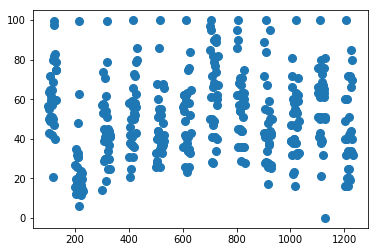

In [4]:
# #Iterate through all powers and assimilate results
# from sklearn import linear_model
# alpha = 0.01

# reg = linear_model.Ridge(alpha=.5)
# las = linear_model.Lasso(alpha=.5)
# lin = linear_model.LinearRegression()

# x_data = data.copy()
# x_data = x_data.drop(columns='y')

# cof = reg.fit(x_data, data['y']) 
# cof_las = las.fit(x_data, data['y'])
# cof_lin = lin.fit(x_data, data['y'])

# print('reg coef: {}'.format(cof.coef_))
# print('las coef: {}'.format(cof_las.coef_))
# print('lin coef: {}'.format(cof_lin.coef_))

# x_data_test = data_test.copy()
# x_data_test = x_data_test.drop(columns='y')

# ypred = reg.predict(x_data_test)
# laspred = las.predict(x_data_test)
# linpred = lin.predict(x_data_test)

# rss_test = sum((ypred - data_test['y'])**2) / 1065
# rss_las_test = sum((laspred - data_test['y']) ** 2) / 1065
# rss_lin_test = sum((linpred - data_test['y']) ** 2) / 1065

# print(rss_test)
# print(rss_las_test)
# print(rss_lin_test)

trainer = Trainer(model=linear_model.Ridge, label='TRANSACTION')

trainer.feed_csv(weather_path, columns=['TAVG', 'DATE', 'TMIN', 'TMAX'])
trainer.feed_csv(gt_path, columns=['STRAWBERRIES', 'DATE', 'TRANSACTION'])
data = trainer.get_dataframe()

trainer.train()
trainer.test()
    

This clearly aligns with our initial understanding. As the model complexity increases, the models tends to fit even smaller deviations in the training data set. We start to fit the gaussian noise in the data (patterns that is not there)

However, as we add more features, we expect ourselves to overfit!

In [5]:
# ypred = reg.predict(x_data_test)

# timest = time.mktime(datetime.datetime.strptime('2018-11-25', "%Y-%m-%d").timetuple())

# plt.plot(data['DATE'],ypred,'.',ms=16);
# plt.plot(data['DATE'],data['y'], '.', ms=16)
# #plt.plot(data['DATE'],laspred,'.',ms=16);
                     
# rss_test = sum((ypred - data_test['y'])**2) / 1065
# rss_test

In [6]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
modeval.results

NameError: name 'modeval' is not defined

It is clearly evident that the size of coefficients increase exponentially with increase in model complexity.

What does a large coefficient signify? 

It means that we’re putting a lot of emphasis on that feature, i.e. the particular feature is a good predictor for the outcome. When it becomes too large, the algorithm starts modelling intricate relations to estimate the output and ends up overfitting to the particular training data.

## Ridge Regression

Note the ‘Ridge’ function used here. It takes ‘alpha’ as a parameter on initialization. Also, keep in mind that normalizing the inputs is generally a good idea in every type of regression and should be used in case of ridge regression as well.

Now, lets analyze the result of Ridge regression for 10 different values of α ranging from 1e-15 to 20. Note that each of these 10 models will contain all the 15 variables and only the value of alpha would differ.

In [ ]:
from sklearn.linear_model import Ridge
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
mods_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}

modeval = ModelEval(data, data_test, models_to_plot = mods_to_plot, alphas=alpha_ridge)
modeval.mod_name('Ridge Regression')

for i in range(10):
    mod = Ridge(alpha = alpha_ridge[i], normalize=True)
    modeval.fit_predict_plot(model=mod, alpha = mod.alpha) 

Here we can clearly observe that as the value of alpha increases, the model complexity reduces. Though higher values of alpha reduce overfitting, significantly high values can cause underfitting as well (eg. alpha = 5). Thus alpha should be chosen wisely. A widely accept technique is cross-validation, i.e. the value of alpha is iterated over a range of values and the one giving higher cross-validation score is chosen.

**USE CROSS VALIDATION**

In [ ]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
modeval.results

### Inference

This straight away gives us the following inferences:

1. The RSS_train increases with increase in alpha, while rss_test is optimized when alpha is around 0.0001 (note edge cases not perfect)
2. An alpha as small as 1e-15 gives us significant reduction in magnitude of coefficients. How? Compare the coefficients in the first row of this table to the last row of simple linear regression table.
3. High alpha values can lead to significant underfitting. Note the rapid increase in RSS for values of alpha greater than 1
4. Though the coefficients are **very very small, they are NOT zero**.


In [ ]:
# count how many of the coefficents are zero (in the full coefficient matrix)

modeval.results.apply(lambda x: sum(x.values==0),axis=1)

We note that none of the coefficients are 0!

## LASSO Regression 
#### (Least Absolute Shrinkage and Selection Operator)

In [ ]:
from sklearn.linear_model import Lasso
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
mods_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

modeval = ModelEval(data, data_test, models_to_plot=mods_to_plot, alphas=alpha_lasso)
modeval.mod_name('Lasso Regression')

for i in range(10):
    mod = Lasso(alpha = alpha_lasso[i], normalize=True, max_iter=1e5)
    modeval.fit_predict_plot(model=mod, alpha = mod.alpha) 

In [ ]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
modeval.results

We have high sparsity whenever a model coefficicent is zero.

Seems to be best around alpha 10^-5 or 10^-4.

### Inference:

Apart from the expected inference of higher RSS for higher alphas, we can see the following:

1. For the same values of alpha, the coefficients of lasso regression are much smaller as compared to that of ridge regression (compare row 1 of the 2 tables).
2. For the same alpha, lasso has higher RSS (poorer fit) as compared to ridge regression
3. Many of the coefficients are zero even for very small values of alpha


In [ ]:
modeval.results.apply(lambda x: sum(x.values==0),axis=1)

We can see that as $\alpha$ increases, the number of coefficients being set to zero increases from 0 to 15. Implicitly, Lasso conducts feature selection as well!

- Lasso works the best with sparsity 

## Conclusion

* Key Differences:
    - Ridge: Typically includes all (or none) of the features in the model. 
        - Main advantage: Coefficient Shrinkage & Reducing Model Complexity
        - It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.
        - Prevents overfitting but does not reduce computational challenges
        - simple gradient descent is capable of the optimization
    - Lasso: 
        - Main advantage: Reduces model complexity & performs coefficient shrinking as well as feature selection
        - Provides sparse solutions
        - requires subgradient optimization in gradient descent

* You can combine Lasso and Ridge Regression via Elastic Nets

## Illustration: Regularizing with Early Stopping

In [ ]:
# ridge with stochastic gradient descent
iterations = [1,5,50,500,5e3,3e4]
plt.subplots(2,3,figsize=(20,14))

predictors=['x']
predictors.extend(['x^%d'%i for i in range(2,16)])

for i in range(6):
    plt.subplot(2,3,i+1)
    its = iterations[i]
    
    model = Ridge(alpha=0, normalize=True,max_iter=its,solver='sag',tol=1e-9)
    model.fit(data[predictors], data['y'])
    y_pred = model.predict(data[predictors])
    plt.plot(data['x'],data['y'],'.',ms=16)
    plt.plot(data['x'],y_pred)
    plt.title('Max Iterations {}'.format(its))